### Sistema Fully Coupled (Girsanov)
$$
\begin{cases}
dS_t =\mu(c-S_t)dt + \sigma_1dW^1_t\\

dH_t = \mu(c-H_t)dt + \sigma_2 dW^2_t\\

dV_t = a(X_t^2 + bH_t + c (e^{t} \mathrm{const}\, Z_t^3\sigma_3^{-1} - X_t)/2)dt + \sigma_3 dW^3_t\\

dX_t = V_t dt

\end{cases}
$$


### Soluzione
$$
    u(t,s,h,v,x) = e^{-t}(e^s + e^{s}h + v^2 + xv)
$$

### Equazione backward
$$

 dY_t = -(Y_t - e^{-t}( (1+H_t)\mu(c-S_t)S_t + \mu(c-H_t)S_t + (2V_t+X_t)a(X_t^2+bH_t+cV_t) +V_t^2 +\sigma_3^2 ) + e^{t} Z_t^3\sigma_3^{-1} a c(\mathrm{const} - 1) Z_t^3\sigma_3^{-1} / 2)dt + Z_t dW_t

$$


In [1]:
## Rete neurale con normalizzazione della loss
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from abc import ABC, abstractmethod

class FBSNN(ABC): # Forward-Backward Stochastic Neural Network
    def __init__(self, Xi, T,
                       M, N, D,
                       layers):

        self.Xi = Xi # initial point
        self.T = T # terminal time

        self.M = M # number of trajectories
        self.N = N # number of time snapshots
        self.D = D # number of dimensions

        # layers
        self.layers = layers # (D+1) --> 1

        # initialize NN
        self.weights, self.biases = self.initialize_NN(layers)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # tf placeholders and graph (training)
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.t_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, 1]) # M x (N+1) x 1
        self.W_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, self.D]) # M x (N+1) x D
        self.Xi_tf = tf.placeholder(tf.float32, shape=[1, D]) # 1 x D

        self.loss, self.X_pred, self.Y_pred, self.Y0_pred, self.Z_pred = self.loss_function(self.t_tf, self.W_tf, self.Xi_tf)

        # optimizers
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)

        # initialize session and variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, t, X): # M x 1, M x D

        u = self.neural_net(tf.concat([t,X], 1), self.weights, self.biases) # M x 1
        Du = tf.gradients(u, X)[0] # M x D

        return u, Du

    def Dg_tf(self, X): # M x D
        return tf.gradients(self.g_tf(X), X)[0] # M x D

    def loss_function(self, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, 1 x D
        loss = 0
        X_list = []
        Y_list = []
        Z_list = []

        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi,[self.M,1]) # M x D
        Y0, Du0 = self.net_u(t0,X0) # M x 1, M x D
        sigma0 = self.sigma_tf(t0, X0, Y0)
        Z0 = tf.squeeze(tf.matmul(tf.expand_dims(Du0, 1), sigma0), axis=1)

        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)

        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            dW = W1 - W0
            sigma_dW = tf.squeeze(tf.matmul(sigma0, tf.expand_dims(dW,-1)), axis=[-1])
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + sigma_dW
            # Z = Du*sigma e nella backward compare Z*dW.
            Y1_tilde = Y0 + self.phi_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.reduce_sum(Z0*dW, axis=1, keepdims = True)
            Y1, Du1 = self.net_u(t1,X1)
            sigma1 = self.sigma_tf(t1, X1, Y1)
            Z1 = tf.squeeze(tf.matmul(tf.expand_dims(Du1, 1), sigma1), axis=1)

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            sigma0 = sigma1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)

        loss += tf.reduce_sum(tf.square(Y1 - self.g_tf(X1)))
        Dg = self.Dg_tf(X1)
        Z_terminal = tf.squeeze(tf.matmul(tf.expand_dims(Dg, 1), sigma1), axis=1)
        loss += tf.reduce_sum(tf.square(Z1 - Z_terminal))

        X = tf.stack(X_list,axis=1)
        Y = tf.stack(Y_list,axis=1)
        Z = tf.stack(Z_list,axis=1)

        return loss/self.N, X, Y, Y[0,0,0], Z

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M,N+1,1)) # M x (N+1) x 1
        DW = np.zeros((M,N+1,D)) # M x (N+1) x D

        dt = T/N

        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D))

        t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
        W = np.cumsum(DW,axis=1) # M x (N+1) x D

        return t, W

    def train(self, N_Iter, learning_rate):

        start_time = time.time()
        for it in range(N_Iter):

            t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D

            tf_dict = {self.Xi_tf: self.Xi, self.t_tf: t_batch, self.W_tf: W_batch, self.learning_rate: learning_rate}

            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, Y0_value, learning_rate_value = self.sess.run([self.loss, self.Y0_pred, self.learning_rate], tf_dict)
                print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, Y0_value, elapsed, learning_rate_value))
                start_time = time.time()


    def predict(self, Xi_star, t_star, W_star):

        tf_dict = {self.Xi_tf: Xi_star, self.t_tf: t_star, self.W_tf: W_star}

        X_star = self.sess.run(self.X_pred, tf_dict)
        Y_star = self.sess.run(self.Y_pred, tf_dict)
        Z_star = self.sess.run(self.Z_pred, tf_dict)

        return X_star, Y_star, Z_star

    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        pass # M x1

    @abstractmethod
    def g_tf(self, X): # M x D
        pass # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M,D]) # M x D

    @abstractmethod
    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M,D])) # M x D x D
    ###########################################################################

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
class NN(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, parameters):
        self.mu = parameters['mu']
        self.c = parameters['c']
        self.b = parameters['b']
        self.a = parameters['a']
        self.s1 = parameters['s1']
        self.s2 = parameters['s2']
        self.s3 = parameters['s3']
        self.const = parameters['const']
        super().__init__(Xi, T, M, N, D, layers)
    
    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        mu = tf.cast(self.mu, tf.float32)
        c = tf.cast(self.c, tf.float32)
        a = tf.cast(self.a, tf.float32)
        b = tf.cast(self.b, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)
        const = tf.cast(self.const, tf.float32)
        #Accoppiamento
        #Z ha dimensione [M, D]. Le colonne sono nella forma
        #[Z_S, Z_H, Z_V, Z_X]
        Z_V = Z[:, 2:3]
        exp_t = tf.exp(t)
        V_from_Z = 0.5 * ((exp_t * const * Z_V / s3) - X_state)
        dS = mu * (c - S)
        dH = mu * (c - H)
        dV = self.a * (X_state**2 + b*H + c*V_from_Z)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)

    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        exp_T = tf.exp(-self.T)
        exp_S = tf.exp(S)
        val = exp_S + (exp_S * H) + (V**2) + (X_state*V)
        return exp_T * val

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        mu = tf.cast(self.mu, tf.float32)
        c = tf.cast(self.c, tf.float32)
        a = tf.cast(self.a, tf.float32)
        b = tf.cast(self.b, tf.float32)
        s1 = tf.cast(self.s1, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)
        const = tf.cast(self.const, tf.float32)
        
        exp_t = tf.exp(-t)
        exp_S = tf.exp(S)

        term1 = (1.0 + H) * (mu * (c - S) * exp_S)
        term2 = mu * (c - H) * exp_S
        Z_V = Z[:, 2:3]
        term3 = (2.0 * V + X_state) * (a * (X_state**2 + b * H + c * V))
        term4 = V**2 + s3**2
        term5 = 0.5 * exp_S * (s1**2) * (1.0 + H)
        
        equation = term1 + term2 + term3 + term4 + term5
        equation = tf.cast(equation, tf.float32)
        z3_scaled = Z_V / s3
        girsanov_corr = 0.5 * tf.exp(t) * z3_scaled * a * c * (const - 1.0) * z3_scaled
        
        return -(Y - (exp_t * equation) + girsanov_corr)
    
    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        s1 = tf.cast(self.s1, tf.float32)
        s2 = tf.cast(self.s2, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)

        zeros = tf.zeros_like(S)
        ones = tf.ones_like(S)

        r1 = tf.concat([s1 * ones, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * ones, zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * ones, zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        return tf.stack([r1, r2, r3, r4], axis=1)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

===WARMUP===
It: 0, Loss: 1.116e+02, Y0: 0.056, Time: 58.84, Learning Rate: 1.000e-04
It: 10, Loss: 5.541e+01, Y0: 0.961, Time: 4.20, Learning Rate: 1.000e-04
It: 20, Loss: 1.761e+01, Y0: 2.046, Time: 4.53, Learning Rate: 1.000e-04
It: 30, Loss: 1.882e+01, Y0: 2.894, Time: 4.26, Learning Rate: 1.000e-04
It: 40, Loss: 1.634e+01, Y0: 2.857, Time: 4.30, Learning Rate: 1.000e-04
It: 50, Loss: 1.368e+01, Y0: 2.668, Time: 4.56, Learning Rate: 1.000e-04
It: 60, Loss: 1.450e+01, Y0: 2.789, Time: 4.30, Learning Rate: 1.000e-04
It: 70, Loss: 1.440e+01, Y0: 3.023, Time: 4.39, Learning Rate: 1.000e-04
It: 80, Loss: 1.291e+01, Y0: 3.136, Time: 4.51, Learning Rate: 1.000e-04
It: 90, Loss: 1.282e+01, Y0: 3.203, Time: 4.34, Learning Rate: 1.000e-04
It: 100, Loss: 1.271e+01, Y0: 3.360, Time: 4.69, Learning Rate: 1.000e-04
It: 110, Loss: 1.159e+01, Y0: 3.506, Time

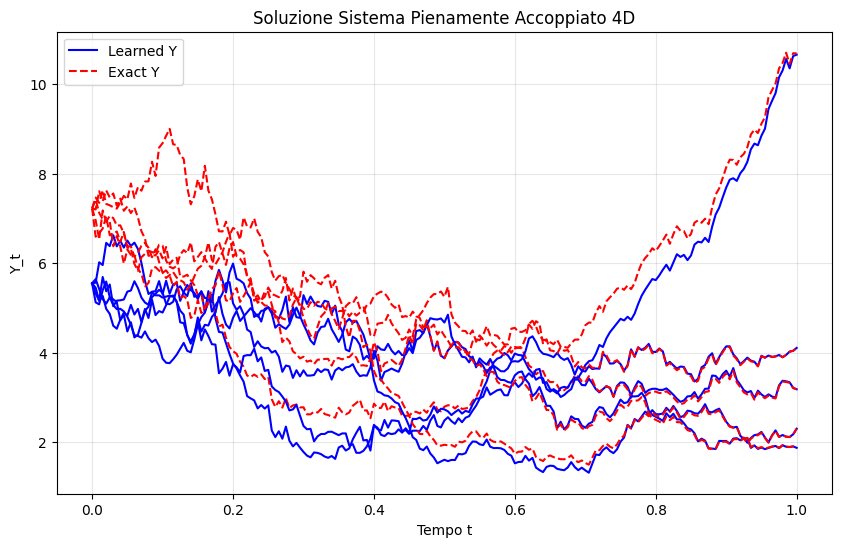

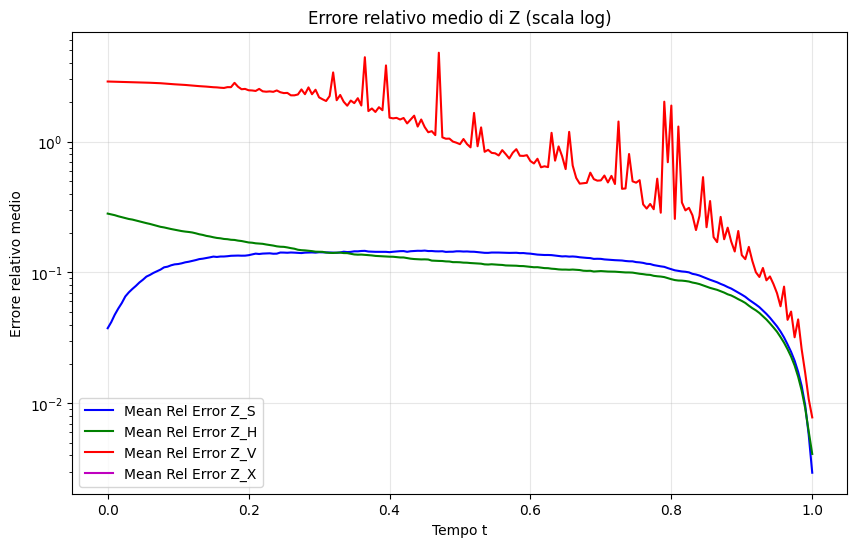

In [3]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    M = 1024
    N = 200
    D = 4
    T = 1.0

    params = {
        'mu': np.float32(1.0),
        'c': np.float32(1.0),
        'b': np.float32(1.0),
        'a': np.float32(1.0),
        's1': np.float32(0.5),
        's2': np.float32(0.5),
        's3': np.float32(0.5),
        'const': np.float32(1.0),
    }

    Xi = np.array([1.5, 0.5, 0.5, 0.5]).reshape(1, D)

    layers = [D+1] + 4*[256] + [1]

    model = NN(Xi, T, M, N, D, layers, params)

    print("===WARMUP===")
    model.train(N_Iter=500, learning_rate=1e-4)

    print("=== Avvio training (High Precision) ===")
    model.train(N_Iter=3000, learning_rate=1e-3)
    model.train(N_Iter=5000, learning_rate=1e-4)
    model.train(N_Iter=5000, learning_rate=1e-5)
    model.train(N_Iter=3000, learning_rate=1e-6)

    # --- PLOTTING ---
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test)

    def u_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X_state = Xi_arr[:, 3:4]
        return np.exp(-t) * (np.exp(S) + np.exp(S)*H + V**2 + X_state*V)

    def z_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X_state = Xi_arr[:, 3:4]

        s1 = params['s1']
        s2 = params['s2']
        s3 = params['s3']

        common = np.exp(-t)
        z_s = common * np.exp(S) * (1.0 + H) * s1
        z_h = common * np.exp(S) * s2
        z_v = common * (2.0 * V + X_state) * s3
        z_x = np.zeros_like(z_s)

        return np.concatenate([z_s, z_h, z_v, z_x], axis=1)

    Xi_reshaped = X_pred.reshape(-1, D)
    t_reshaped = t_test.reshape(-1, 1)

    Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, 1)
    Z_exact = z_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, D)

    exact_Y0 = u_exact(np.array([[0.0]]), Xi)[0, 0]
    print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:     {exact_Y0:.4f}")

    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
    plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
    plt.plot(t_test[1:5,:,0].T, Y_pred[1:5,:,0].T, 'b')
    plt.plot(t_test[1:5,:,0].T, Y_exact[1:5,:,0].T, 'r--')
    plt.title("Soluzione Sistema Pienamente Accoppiato 4D")
    plt.xlabel("Tempo t")
    plt.ylabel("Y_t")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Errore relativo medio sui componenti di Z (stile log_z, ma corretto per ogni componente)
    eps = 1e-8
    rel_err_Z = np.abs((Z_pred - Z_exact) / (np.abs(Z_exact) + eps))
    mean_rel_err_Z = np.mean(rel_err_Z, axis=0)  # (N+1, D)

    labels = ['Z_S', 'Z_H', 'Z_V', 'Z_X']
    colors = ['b', 'g', 'r', 'm']

    plt.figure(figsize=(10,6))
    for d in range(D):
        plt.plot(t_test[0,:,0], mean_rel_err_Z[:, d], colors[d], label=f'Mean Rel Error {labels[d]}')
    plt.yscale('log')
    plt.title('Errore relativo medio di Z (scala log)')
    plt.xlabel('Tempo t')
    plt.ylabel('Errore relativo medio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
